# Exploratory Data Analysis for the Class Enrollment Numbers

We are exporting class data from PeopleSoft CLASS_TBL. The table has the following columns of significance:
 - STRM - Refers to the class term (4 in a year). Some classes are scheduled every term, some are just once per year
 - CRSE_ID - Course ID - doesn't chance class-to-class
 - CLASS_NBR - Class number - unique identifier for the class
 - ROOM_CAP_REQUEST - how large is the room that's requested for this class
 - ENRL_TOT - how many students are enrolled in this class
 - ENRL_CAP - how many students class has the capacity for
 - Some course can have multiple classes (lecture / lecture + lab or tut (can skip them for now SSR_COMPONENT=LEC))

So we are trying to answer the following questions:
 * What are the most popular classes?
 * Which classes have the largest capacity gap between actual / requested?
 * What is the ideal capacity?
 * Can we predict class enrollments for future sessions?

## Importing Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
all_classes = pd.read_csv('class_tbl_lectures_only.csv', index_col='CLASS_NBR', encoding='cp1252', low_memory=False)
all_classes['STRM'] = all_classes['STRM'].astype(str)
all_classes.head()

,CRSE_ID,CRSE_OFFER_NBR,STRM,SESSION_CODE,CLASS_SECTION,INSTITUTION,ACAD_GROUP,SUBJECT,CATALOG_NBR,ACAD_CAREER,...,WRITEOFF_AFF_INT2,EXT_WRITEOFF,GL_INTERFACE_REQ,LMS_FILE_TYPE,LMS_GROUP_ID,LMS_URL,LMS_CLASS_EXT_DTTM,LMS_ENRL_EXT_DTTM,LMS_PROVIDER,SSR_DROP_CONSENT
CLASS_NBR,,,,,,,,,,,,,,,,,,,,,
10434,100060,1,2159,1,C01,MCMST,15,ANTHROP,1AA3,UGRD,...,,,N,,,,NaN,NaN,,N
13454,100060,1,2159,1,C02,MCMST,15,ANTHROP,1AA3,UGRD,...,,,N,,,,NaN,NaN,,N
13442,100061,1,2159,1,C01,MCMST,15,ANTHROP,1AB3,UGRD,...,,,N,,,,NaN,NaN,,N
13466,100088,1,2159,1,C01,MCMST,15,ANTHROP,2E03,UGRD,...,,,N,,,,NaN,NaN,,N
10468,100093,1,2159,1,C01,MCMST,15,ANTHROP,2FF3,UGRD,...,,,N,,,,NaN,NaN,,N


## Cleanup

In [3]:
# Keep relevant columns only
classes = all_classes[['CRSE_ID', 'CRSE_OFFER_NBR', 'STRM', 'SESSION_CODE', 'CLASS_SECTION', 'ACAD_GROUP', 'SUBJECT', 'CATALOG_NBR', 'ACAD_CAREER', 'DESCR', 'ENRL_STAT', 'ENRL_TOT', 'ENRL_CAP']]

# Make sure we only use classes with some enrollments
classes = classes[classes['STRM'] == '2189']
classes = classes[classes['ENRL_TOT'] > 2]
classes = classes[classes['SUBJECT'] != 'BIOSAFE']
classes = classes[classes['SUBJECT'] != 'WHMIS']
classes = classes[classes['SUBJECT'] != 'SGS']
classes = classes[classes['SUBJECT'] != 'MED']
classes.head()
classes.dropna(inplace=True)

In [4]:
classes.head()

,CRSE_ID,CRSE_OFFER_NBR,STRM,SESSION_CODE,CLASS_SECTION,ACAD_GROUP,SUBJECT,CATALOG_NBR,ACAD_CAREER,DESCR,ENRL_STAT,ENRL_TOT,ENRL_CAP
CLASS_NBR,,,,,,,,,,,,,
13740,100060,1,2189,1,C01,15,ANTHROP,1AA3,UGRD,"Sex, Food & Death",O,468,475
13830,100060,1,2189,1,C02,15,ANTHROP,1AA3,UGRD,"Sex, Food & Death",O,395,400
13829,100061,1,2189,1,C01,15,ANTHROP,1AB3,UGRD,"Race, Religion, and Conflict",O,372,375
16367,100085,1,2189,1,C01,15,ANTHROP,2D03,UGRD,DNA Meets Anthropology,O,44,45
14594,100088,1,2189,1,C01,15,ANTHROP,2E03,UGRD,Intro to Biological Anthro,O,132,150


In [5]:
classes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 13740 to 13636
Data columns (total 13 columns):
CRSE_ID           1990 non-null int64
CRSE_OFFER_NBR    1990 non-null int64
STRM              1990 non-null object
SESSION_CODE      1990 non-null object
CLASS_SECTION     1990 non-null object
ACAD_GROUP        1990 non-null int64
SUBJECT           1990 non-null object
CATALOG_NBR       1990 non-null object
ACAD_CAREER       1990 non-null object
DESCR             1990 non-null object
ENRL_STAT         1990 non-null object
ENRL_TOT          1990 non-null int64
ENRL_CAP          1990 non-null int64
dtypes: int64(5), object(8)
memory usage: 217.7+ KB


In [6]:
classes['LABEL'] = classes[['SUBJECT', 'CATALOG_NBR', 'CLASS_SECTION']].apply(lambda x: ' '.join(map(str, x)), axis=1)

## What are the most popular classes?

In [7]:
most_popular_classes = classes.sort_values('ENRL_TOT',ascending = False).head(50)

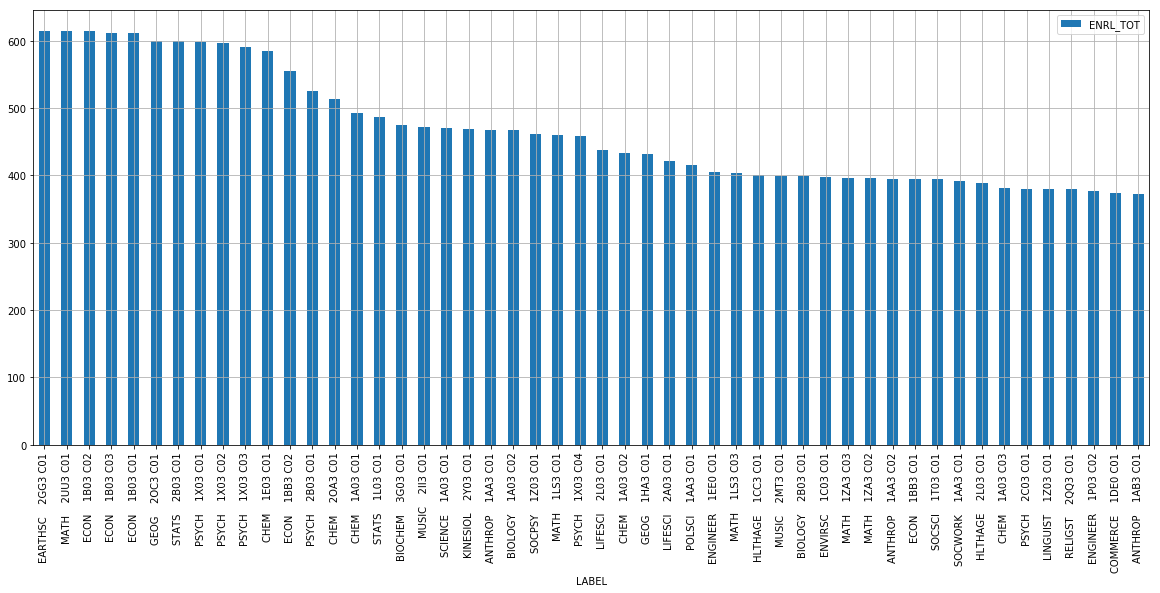

In [8]:
most_popular_classes.plot(x='LABEL', y='ENRL_TOT', kind='bar', figsize=(20, 8), grid=True )

## Which classes have the largest capacity gap between actual / requested?

In [9]:
classes['CAPACITY_GAP'] = classes['ENRL_CAP'] - classes['ENRL_TOT']
cap_gap_classes = classes.sort_values('CAPACITY_GAP',ascending = False).head(50)

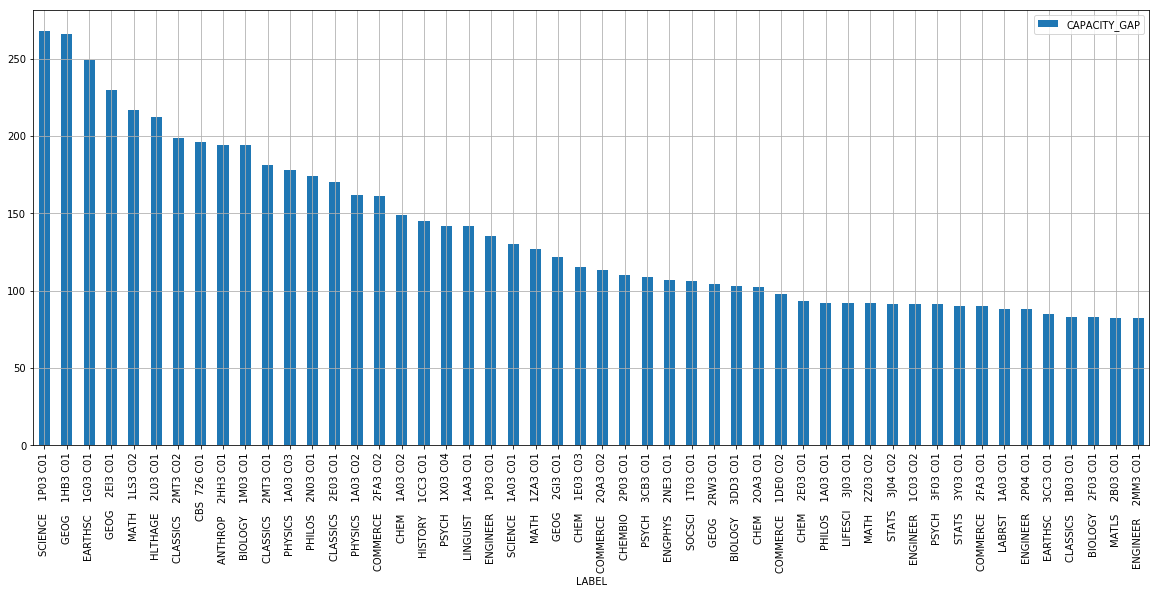

In [10]:
cap_gap_classes.plot(x='LABEL', y='CAPACITY_GAP', kind='bar', figsize=(20, 8), grid=True )

In [11]:
cap_gap_classes.head(100)

,CRSE_ID,CRSE_OFFER_NBR,STRM,SESSION_CODE,CLASS_SECTION,ACAD_GROUP,SUBJECT,CATALOG_NBR,ACAD_CAREER,DESCR,ENRL_STAT,ENRL_TOT,ENRL_CAP,LABEL,CAPACITY_GAP
CLASS_NBR,,,,,,,,,,,,,,,
16425,123693,1,2189,1,C01,2,SCIENCE,1P03,UGRD,Impactful Initiatives in Hlth,O,32,300,SCIENCE 1P03 C01,268
10088,107654,1,2189,1,C01,2,GEOG,1HB3,UGRD,Human Geo:City&Economy,O,209,475,GEOG 1HB3 C01,266
10122,105563,1,2189,1,C01,2,EARTHSC,1G03,UGRD,Earth & The Environment,O,151,400,EARTHSC 1G03 C01,249
10547,107671,1,2189,1,C01,2,GEOG,2EI3,UGRD,Environmental Issues,O,245,475,GEOG 2EI3 C01,230
10071,111071,1,2189,1,C02,2,MATH,1LS3,UGRD,Calculus For Life Sciences I,O,163,380,MATH 1LS3 C02,217
14103,122968,1,2189,1,C01,15,HLTHAGE,2L03,UGRD,Society and its Addictions,O,388,600,HLTHAGE 2L03 C01,212
13407,103725,1,2189,1,C02,14,CLASSICS,2MT3,UGRD,Ancient Roots:Med Terminology,O,276,475,CLASSICS 2MT3 C02,199
16301,122324,1,2189,1,C01,12,CBS,726,GRAD,Intro to Post-Traumatic Stress,O,4,200,CBS 726 C01,196
14678,123436,1,2189,1,C01,15,ANTHROP,2HH3,UGRD,"Eng, Mining & Tech: Arch Persp",O,56,250,ANTHROP 2HH3 C01,194


## What is the ideal capacity?

In [12]:
classes['IDEAL_CLASS_SIZE'] = classes['ENRL_TOT'] * 1.1
classes['IDEAL_CLASS_SIZE'] = classes['IDEAL_CLASS_SIZE'].astype(int)
classes['IDEAL_CAPACITY_GAP'] = classes['ENRL_CAP'] - classes['IDEAL_CLASS_SIZE']
ideal_cap_gap_classes = classes.sort_values('IDEAL_CAPACITY_GAP',ascending = False).head(50)

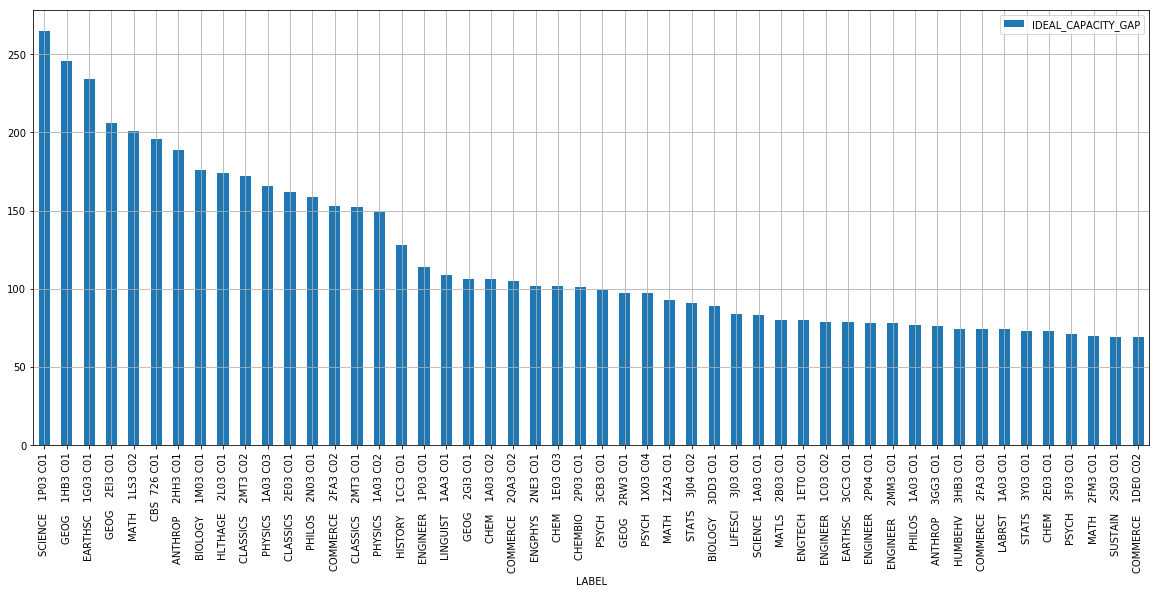

In [13]:
ideal_cap_gap_classes.plot(x='LABEL', y='IDEAL_CAPACITY_GAP', kind='bar', figsize=(20, 8), grid=True )

In [14]:
print("Will be able to save capacity of " + str(classes['IDEAL_CAPACITY_GAP'].sum()) + " seats for " + (",".join(classes['STRM'].astype(str).unique())) + " term(s)")

Will be able to save capacity of 18638 seats for 2189 term(s)


## Can we predict class enrollments for future sessions?

In [15]:
import seaborn as sns
sns.set_style('whitegrid')

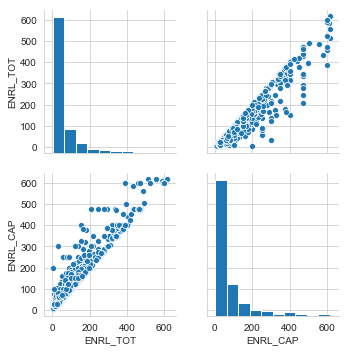

In [16]:
sns.pairplot(classes[['ENRL_TOT', 'ENRL_CAP']])

In [17]:
print("There is a total of " + str(len(classes['LABEL'].unique())) + " unique classes")

There is a total of 1989 unique classes


In [18]:
geog_1hb3_df = all_classes[all_classes['SUBJECT'] == 'GEOG']
geog_1hb3_df = geog_1hb3_df[geog_1hb3_df['CATALOG_NBR'] == '   1HB3']

In [19]:
geog_1hb3_df.sort_values('STRM',ascending = False)
geog_1hb3_df.head(15)

,CRSE_ID,CRSE_OFFER_NBR,STRM,SESSION_CODE,CLASS_SECTION,INSTITUTION,ACAD_GROUP,SUBJECT,CATALOG_NBR,ACAD_CAREER,...,WRITEOFF_AFF_INT2,EXT_WRITEOFF,GL_INTERFACE_REQ,LMS_FILE_TYPE,LMS_GROUP_ID,LMS_URL,LMS_CLASS_EXT_DTTM,LMS_ENRL_EXT_DTTM,LMS_PROVIDER,SSR_DROP_CONSENT
CLASS_NBR,,,,,,,,,,,,,,,,,,,,,
10262,107654,1,2159,1,C01,MCMST,2,GEOG,1HB3,UGRD,...,,,N,,,,NaN,NaN,,N
10094,107654,1,2161,1,C02,MCMST,2,GEOG,1HB3,UGRD,...,,,N,,,,NaN,NaN,,N
10707,107654,1,2165,7W1,C01,MCMST,2,GEOG,1HB3,UGRD,...,,,N,,,,NaN,NaN,,N
10095,107654,1,2169,1,C01,MCMST,2,GEOG,1HB3,UGRD,...,,,N,,,,NaN,NaN,,N
10073,107654,1,2171,1,C02,MCMST,2,GEOG,1HB3,UGRD,...,,,N,,,,NaN,NaN,,N
10091,107654,1,2179,1,C01,MCMST,2,GEOG,1HB3,UGRD,...,,,N,,,,NaN,NaN,,N
10068,107654,1,2181,1,C02,MCMST,2,GEOG,1HB3,UGRD,...,,,N,,,,NaN,NaN,,N
11110,107654,1,2185,7W1,C01,MCMST,2,GEOG,1HB3,UGRD,...,,,N,,,,NaN,NaN,,N
10088,107654,1,2189,1,C01,MCMST,2,GEOG,1HB3,UGRD,...,,,N,,,,NaN,NaN,,N


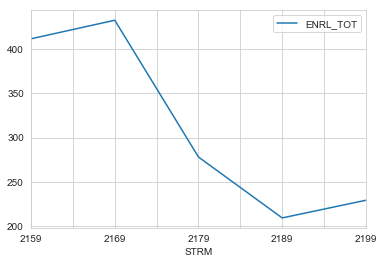

In [20]:
# STRM - ends in 5 - spring/summer
# STRM - ends in 1 - winter
# STRM - ends in 9 - fall

fall_geog_1hb3_df = geog_1hb3_df[geog_1hb3_df['STRM'].apply(lambda x: str(x).endswith('9'))]
fall_geog_1hb3_df.plot(x='STRM', y='ENRL_TOT', kind='line', grid=True)

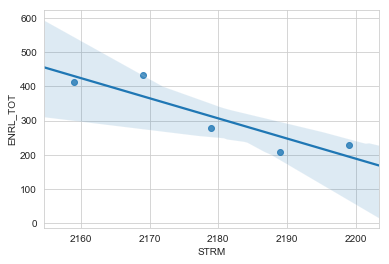

In [22]:
# Fitting a linear model
sns.regplot(fall_geog_1hb3_df['STRM'].astype(int), fall_geog_1hb3_df['ENRL_TOT'])

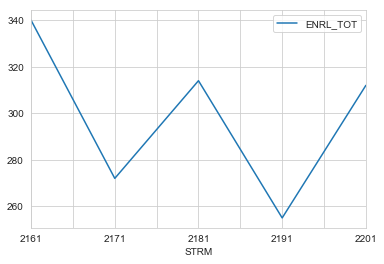

In [23]:
wint_geog_1hb3_df = geog_1hb3_df[geog_1hb3_df['STRM'].apply(lambda x: str(x).endswith('1'))]
wint_geog_1hb3_df.plot(x='STRM', y='ENRL_TOT', kind='line', grid=True)

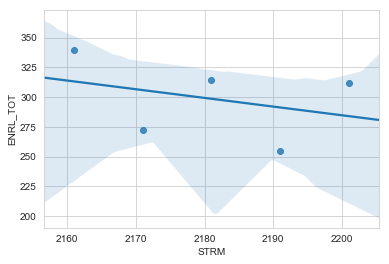

In [24]:
sns.regplot(wint_geog_1hb3_df['STRM'].astype(int), wint_geog_1hb3_df['ENRL_TOT'])